# **Master in Data Science and Engineering**

## MECD 11 - Analysis of Complex Data    </small>  
**Professors:** Carlos Soares, Henrique Cardoso e João Moreira<br>

* Fabiana Rodrigues da Silva
* Gabriel Copolecchia Carvalhal
* Guilherme Carlos Salles

##Imports

In [67]:
!pip install --quiet nltk
!pip install geopandas
import nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [68]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [69]:
import json
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from nltk.corpus import stopwords 
from nltk.tokenize import WordPunctTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [70]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Data preparation: Import all the data from YELP dateset

In [71]:
#path = '/content/gdrive/MyDrive/10_ColabNotebooks/AdvancedML_Dataset/ADC/Project_ADC/'
#path_business  = '/content/gdrive/MyDrive/10_ColabNotebooks/AdvancedML_Dataset/ADC/Project_ADC/yelp_academic_dataset_business.json'
#path_review  = '/content/gdrive/MyDrive/10_ColabNotebooks/AdvancedML_Dataset/ADC/Project_ADC/yelp_academic_dataset_review.json'

path = '/content/gdrive/My Drive/Mestrado/3_semestre/ADC/Project_ADC/'
path_business = '/content/gdrive/My Drive/Mestrado/3_semestre/ADC/Project_ADC/yelp_academic_dataset_business.json'
path_review  = '/content/gdrive/My Drive/Mestrado/3_semestre/ADC/Project_ADC/yelp_academic_dataset_review.json'

In [72]:
business = pd.read_json(path_business, lines=True)


In [73]:
business.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."


In [74]:
#Strategy to read maxium reviews as possible without crash
users = []
with open(path_review) as fl:
    for i, line in enumerate(fl):
        users.append(json.loads(line))
        if i+1 >= 4000000:
            break
rev = pd.DataFrame(users)

In [75]:
rev.head(2)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18


### Data preparation: Filtering Restaurants in CA


In [76]:
## Filter by the business on the State of CA

business_ca = business[business['state']=='CA']
business_ca.head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
26,noByYNtDLQAra9ccqxdfDw,H&M,827-833 State St,Santa Barbara,CA,93101,34.420209,-119.700460,3.0,24,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Women's Clothing, Accessories, Children's Clot...","{'Monday': '11:0-18:0', 'Tuesday': '11:0-18:0'..."
85,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,"131 Anacapa St, Ste C",Santa Barbara,CA,93101,34.414445,-119.690672,4.0,389,1,"{'RestaurantsTakeOut': 'True', 'NoiseLevel': '...","Food, Restaurants, Salad, Coffee & Tea, Breakf...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-14:0', '..."


In [77]:
#business_ca.count()
#business_ca.categories.unique

In [78]:
#Filtering by category Restaurant
business_ca_rest = business_ca[business_ca['categories'].str.contains('estau', na=False)]

In [79]:
#only Restaurants that still open
#reducing from 1116 to 668
business_ca_rest = business_ca_rest[business_ca_rest['is_open']==1]

In [80]:
#Exporting as csv
business_ca_rest.to_csv(path+'business_ca_restaurants.csv', index=False)

### Data preparation: Filtering reviews from Restaurants in CA

In [81]:
list_business_ca = business_ca_rest['business_id'].tolist()

In [82]:
rev_ca = rev[rev['business_id'].isin(list_business_ca)]

In [83]:
rev_ca.count()

review_id      89888
user_id        89888
business_id    89888
stars          89888
useful         89888
funny          89888
cool           89888
text           89888
date           89888
dtype: int64

In [84]:
rev_ca.head(15)
rev_ca_2018=rev_ca[rev_ca['date'] >= '2018-01-01']

In [85]:
rev_ca_2018.count()

review_id      37691
user_id        37691
business_id    37691
stars          37691
useful         37691
funny          37691
cool           37691
text           37691
date           37691
dtype: int64

In [86]:
#Exporting as csv
rev_ca_2018.to_csv(path+'review_ca_restaurants.csv', index=False)

## Import data from Yelp: California Restaurants after 2018

In [87]:
path = '/content/gdrive/MyDrive/10_ColabNotebooks/AdvancedML_Dataset/ADC/Project_ADC/'

path_business_ca  = '/content/gdrive/MyDrive/10_ColabNotebooks/AdvancedML_Dataset/ADC/Project_ADC/business_ca_restaurants.csv'
path_review_ca  = '/content/gdrive/MyDrive/10_ColabNotebooks/AdvancedML_Dataset/ADC/Project_ADC/review_ca_restaurants.csv'


path = '/content/gdrive/My Drive/Mestrado/3_semestre/ADC/Project_ADC/'
path_business_ca = '/content/gdrive/My Drive/Mestrado/3_semestre/ADC/Project_ADC/business_ca_restaurants.csv'
path_review_ca  = '/content/gdrive/My Drive/Mestrado/3_semestre/ADC/Project_ADC/review_ca_restaurants.csv'

In [88]:
df_business = pd.read_csv(path_business_ca)

In [89]:
df_business.head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,"131 Anacapa St, Ste C",Santa Barbara,CA,93101,34.414445,-119.690672,4.0,389,1,"{'RestaurantsTakeOut': 'True', 'NoiseLevel': ""...","Food, Restaurants, Salad, Coffee & Tea, Breakf...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-14:0', '..."
1,SZU9c8V2GuREDN5KgyHFJw,Santa Barbara Shellfish Company,230 Stearns Wharf,Santa Barbara,CA,93101,34.408715,-119.685019,4.0,2404,1,"{'OutdoorSeating': 'True', 'RestaurantsAttire'...","Live/Raw Food, Restaurants, Seafood, Beer Bar,...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:0', ..."
2,ifjluUv4VASwmFqEp8cWlQ,Marty's Pizza,2733 De La Vina St,Santa Barbara,CA,93105,34.436236,-119.726147,4.0,64,1,"{'Alcohol': ""u'none'"", 'BusinessAcceptsCreditC...","Pizza, Restaurants","{'Tuesday': '11:0-21:30', 'Wednesday': '11:0-2..."


In [90]:
df_rev = pd.read_csv(path_review_ca)

In [91]:
df_rev.head(3)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,b1GkT5ojVlMCM6jdwPi3wQ,JcUxoKPqBBRaMcHaQOYFlg,_v3DcLatG70adfYzWTd-CQ,5.0,0,0,0,Best smoothies in the whole world. And fresh b...,2018-04-04 00:31:57
1,s_X5uNLjLSgK_itDNFiadg,NZdASLiCRqQI1yIl9MIY5w,MbzgGsMQpGyVrUJXi_Jw0Q,4.0,0,0,0,I am from Colorado and am visiting Santa Barba...,2018-03-15 19:16:02
2,Q3fPo_x6xKxafAzy1hFITg,ha2Lv7WnxvdYnRsqwL1apQ,IDtLPgUrqorrpqSLdfMhZQ,4.0,0,0,0,Pricey ( a ham and cheese croissant was $5.50)...,2018-07-17 00:20:41


## Data Exploration

In [92]:
df_business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,"131 Anacapa St, Ste C",Santa Barbara,CA,93101,34.414445,-119.690672,4.0,389,1,"{'RestaurantsTakeOut': 'True', 'NoiseLevel': ""...","Food, Restaurants, Salad, Coffee & Tea, Breakf...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-14:0', '..."
1,SZU9c8V2GuREDN5KgyHFJw,Santa Barbara Shellfish Company,230 Stearns Wharf,Santa Barbara,CA,93101,34.408715,-119.685019,4.0,2404,1,"{'OutdoorSeating': 'True', 'RestaurantsAttire'...","Live/Raw Food, Restaurants, Seafood, Beer Bar,...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:0', ..."
2,ifjluUv4VASwmFqEp8cWlQ,Marty's Pizza,2733 De La Vina St,Santa Barbara,CA,93105,34.436236,-119.726147,4.0,64,1,"{'Alcohol': ""u'none'"", 'BusinessAcceptsCreditC...","Pizza, Restaurants","{'Tuesday': '11:0-21:30', 'Wednesday': '11:0-2..."
3,VeFfrEZ4iWaecrQg6Eq4cg,Cal Taco,"7320 Hollister Ave, Ste 1",Goleta,CA,93117,34.430542,-119.882367,4.0,189,1,"{'RestaurantsGoodForGroups': 'True', 'Business...","Burgers, Cafes, Restaurants, Mexican, American...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-20:30', ..."
4,bdfZdB2MTXlT6-RBjSIpQg,Pho Bistro,903 Embarcadero Del Norte,Isla Vista,CA,93117,34.412934,-119.855531,3.0,184,1,"{'RestaurantsDelivery': 'True', 'BikeParking':...","Food, Restaurants, Chinese, Bubble Tea, Vietna...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."


Distribution (count) of **Restaurant Ratings**

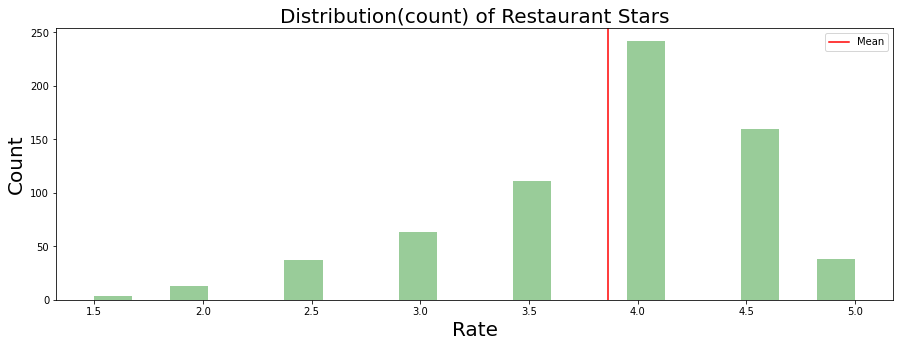

In [93]:
#Distribution of Restaurant Rating 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
sns.distplot(df_business.stars,kde=False,color = 'g',ax =ax,bins=20);
ax.axvline(df_business.stars.mean(), 0, 1, color='r', label='Mean')
ax.legend();
ax.set_ylabel('Count',size=20)
ax.set_xlabel('Rate',size=20)
ax.set_title('Distribution(count) of Restaurant Stars',size=20)
fig.show()

Top 10 Reviewed Restaurants in California 

Text(0.5, 1.0, 'Top 10 Restaurants with Reviews')

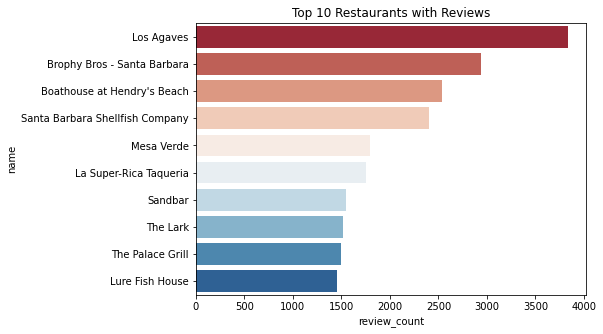

In [94]:
df_rating = df_business.sort_values(by='review_count', ascending=False).head(10)
plt.figure(figsize=(7,5))
sns.barplot(data=df_rating, x='review_count', y='name', palette='RdBu')
plt.title('Top 10 Restaurants with Reviews')

Top 20 - word frequency for cuisines


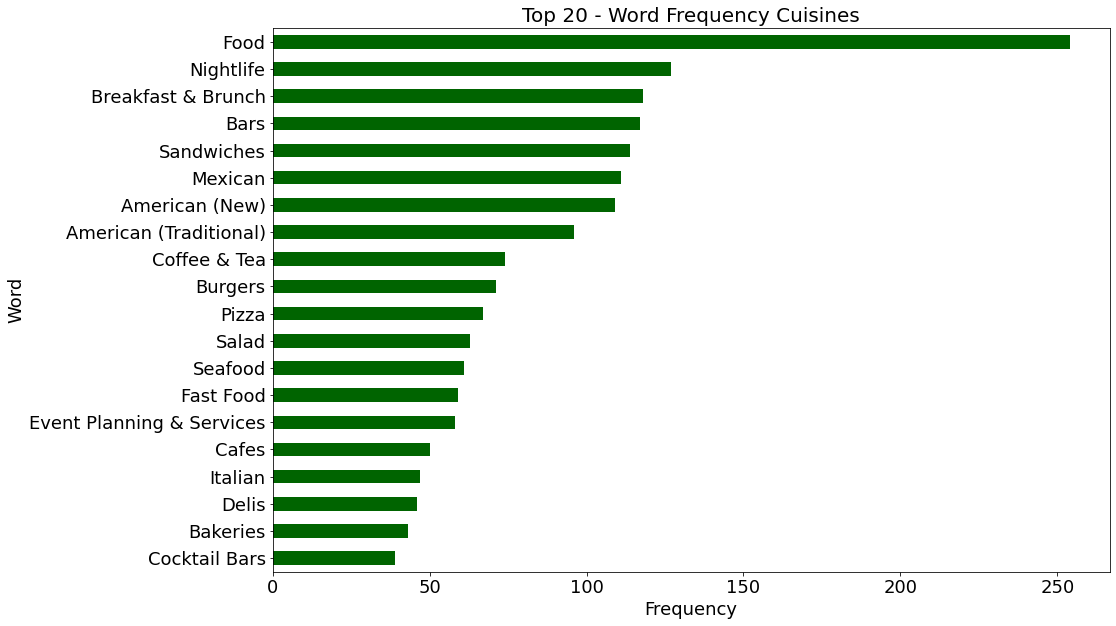

In [95]:
#Data preparation
#split
comma = df_business['categories'].str.split(', ')
df_comma = comma.explode('categories')
#count
counts = df_comma.value_counts()[1:21]
#plot
p = counts.sort_values().plot.barh(figsize=(15,10), fontsize=18,color = 'darkgreen') 
p.set_xlabel("Frequency",fontsize=18) 
p.set_ylabel("Word",fontsize=18)
p.set_title("Top 20 - Word Frequency Cuisines", fontsize=20)
plt.show()

Plotting Restautants Map

In [96]:
import folium

In [97]:
df_business.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,"131 Anacapa St, Ste C",Santa Barbara,CA,93101,34.414445,-119.690672,4.0,389,1,"{'RestaurantsTakeOut': 'True', 'NoiseLevel': ""...","Food, Restaurants, Salad, Coffee & Tea, Breakf...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-14:0', '..."
1,SZU9c8V2GuREDN5KgyHFJw,Santa Barbara Shellfish Company,230 Stearns Wharf,Santa Barbara,CA,93101,34.408715,-119.685019,4.0,2404,1,"{'OutdoorSeating': 'True', 'RestaurantsAttire'...","Live/Raw Food, Restaurants, Seafood, Beer Bar,...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:0', ..."
2,ifjluUv4VASwmFqEp8cWlQ,Marty's Pizza,2733 De La Vina St,Santa Barbara,CA,93105,34.436236,-119.726147,4.0,64,1,"{'Alcohol': ""u'none'"", 'BusinessAcceptsCreditC...","Pizza, Restaurants","{'Tuesday': '11:0-21:30', 'Wednesday': '11:0-2..."
3,VeFfrEZ4iWaecrQg6Eq4cg,Cal Taco,"7320 Hollister Ave, Ste 1",Goleta,CA,93117,34.430542,-119.882367,4.0,189,1,"{'RestaurantsGoodForGroups': 'True', 'Business...","Burgers, Cafes, Restaurants, Mexican, American...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-20:30', ..."
4,bdfZdB2MTXlT6-RBjSIpQg,Pho Bistro,903 Embarcadero Del Norte,Isla Vista,CA,93117,34.412934,-119.855531,3.0,184,1,"{'RestaurantsDelivery': 'True', 'BikeParking':...","Food, Restaurants, Chinese, Bubble Tea, Vietna...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."


In [98]:
df_business_map = df_business[["latitude", "longitude", "name", "city"]]

In [99]:
df_business_map.head(5)

,latitude,longitude,name,city
0,34.414445,-119.690672,Helena Avenue Bakery,Santa Barbara
1,34.408715,-119.685019,Santa Barbara Shellfish Company,Santa Barbara
2,34.436236,-119.726147,Marty's Pizza,Santa Barbara
3,34.430542,-119.882367,Cal Taco,Goleta
4,34.412934,-119.855531,Pho Bistro,Isla Vista


In [100]:
map = folium.Map(location=[df_business_map.latitude.mean(), df_business_map.longitude.mean()], zoom_start=14, control_scale=True)

In [101]:
map

In [102]:
df_business_map['city'].unique()

array(['Santa Barbara', 'Goleta', 'Isla Vista', 'Carpinteria',
       'Montecito', 'Summerland', 'Santa  Barbara', 'Truckee'],
      dtype=object)

In [103]:
 def color(city):
    if city in ('Santa Barbara','Santa  Barbara'):
        col = 'green'
    elif city== 'Goleta':
        col = 'blue'
    elif city=='Isla Vista':
        col = 'orange'
    elif city=='Carpinteria':
        col = 'yellow'
    elif city=='Montecito':
        col = 'darkblue'
    elif city=='Summerland':
        col = 'gray'    
    else:
        col='red'
    #print(city)    
    return col

In [104]:
df_business_map

,latitude,longitude,name,city
0,34.414445,-119.690672,Helena Avenue Bakery,Santa Barbara
1,34.408715,-119.685019,Santa Barbara Shellfish Company,Santa Barbara
2,34.436236,-119.726147,Marty's Pizza,Santa Barbara
3,34.430542,-119.882367,Cal Taco,Goleta
4,34.412934,-119.855531,Pho Bistro,Isla Vista
...,...,...,...,...
663,34.428599,-119.688223,Cesar's Place,Santa Barbara
664,34.422291,-119.705339,Sushi Bar 29,Santa Barbara
665,34.416548,-119.695626,Oat Bakery,Santa Barbara
666,34.440885,-119.823523,Nikka Ramen,Goleta


In [105]:
#for index, location_info in df_business_map.iterrows():
#folium.Marker([location_info["latitude"], location_info["longitude"]], popup=location_info["name"]).add_to(map)

for lat,lan,name,city in zip(df_business_map['latitude'],df_business_map['longitude'], df_business_map['name'], df_business_map['city']):
     folium.Marker(location=[lat,lan],popup = name,
                  icon= folium.Icon(color=color(city),icon='')
              ).add_to(map)

In [106]:
map

Number of restaurants per city

Text(0, 0.5, 'Cities')

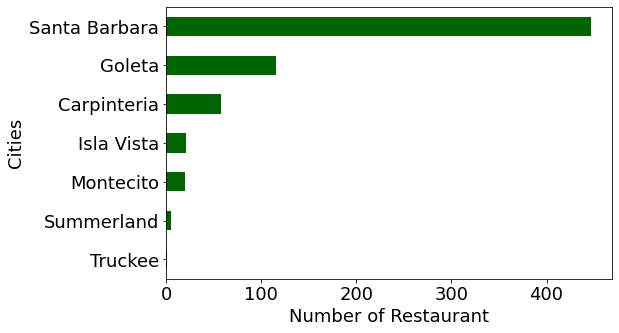

In [107]:
df_business_map['city'].replace('Santa  Barbara', 'Santa Barbara', inplace=True)
counts = df_business_map["city"].value_counts()
p = counts.sort_values().plot.barh(figsize=(8,5), fontsize=18, color = 'darkgreen') 
p.set_xlabel("Number of Restaurant",fontsize=18) 
p.set_ylabel("Cities",fontsize=18)

## NLP Pre-processing

In [108]:
#Selct only stars and text
yelp_data = df_rev[['business_id', 'user_id', 'stars', 'text']]

Takes in a string of text, then performs the following:
1. Remove all punctuation
2. Remove all stopwords
3. Returns a list of the cleaned text

In [109]:
stop = []
for word in stopwords.words('english'):
    s = [char for char in word if char not in string.punctuation]
    stop.append(''.join(s))

In [110]:
def text_process(mess):
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    # Now just remove any stopwords
    return " ".join([word for word in nopunc.split() if word.lower() not in stop])


### Clean text

In [111]:
yelp_data['text'] = yelp_data['text'].apply(text_process)

### Create two tables of user, text and business text

In [112]:
userid_df = yelp_data[['user_id','text']]
business_df = yelp_data[['business_id', 'text']]
business_df_c = business_df

In [113]:
userid_df.head()

,user_id,text
0,JcUxoKPqBBRaMcHaQOYFlg,Best smoothies whole world fresh bread amazing...
1,NZdASLiCRqQI1yIl9MIY5w,Colorado visiting Santa Barbara let tell great...
2,ha2Lv7WnxvdYnRsqwL1apQ,Pricey ham cheese croissant 550 anywhere Santa...
3,O9B-8noN7pKAR46fb_O0YA,happy found bomb local sushi place Always igno...
4,sWyRv7ucsU3qWcBtFMs0uw,think Dawn Patrol could become 4 stars yet lik...


In [114]:
business_df.head()

,business_id,text
0,_v3DcLatG70adfYzWTd-CQ,Best smoothies whole world fresh bread amazing...
1,MbzgGsMQpGyVrUJXi_Jw0Q,Colorado visiting Santa Barbara let tell great...
2,IDtLPgUrqorrpqSLdfMhZQ,Pricey ham cheese croissant 550 anywhere Santa...
3,DzpaiMQnB_sNhZPrgdvKHg,happy found bomb local sushi place Always igno...
4,MbzgGsMQpGyVrUJXi_Jw0Q,think Dawn Patrol could become 4 stars yet lik...


In [115]:
#Group By user id
userid_df = userid_df.groupby('user_id').agg({'text': ' '.join})
business_df = business_df.groupby('business_id').agg({'text': ' '.join})

In [116]:
userid_df.head()

,text
user_id,
--2F5G5LKt3h2cAXJbZptg,Cool little place hidden way mans land Food go...
--56mD0sm1eOogphi2FFLw,Came birthday dinner definitely disappointed C...
--8Y8seruJEgwgwznJGyZA,poke probably best Santa Barbara get matcha ic...
--8YG4BoOWFGjdh9Fxop-w,Really good coffee 40 years older clients matt...
--CprxtcUfzKoz29hAzm5w,beer food awesome beer everyone double ipa ipa...


In [117]:
business_df.head()

,text
business_id,
-3AooxIkg38UyUdlz5oXdw,Wow Wow Weve trying go reason another happened...
-ALqLSTzkGDMscHdxA1NgA,came feeling sick ordered caldo de res open th...
-H-fZonTLitwHFY_PLAIjA,MedBridge loves Taffys company Valentines Pizz...
-I7M6l0h46VdiN09Y1NUZw,Saffron rice Saag Paneer Skip ish Go Apna old ...
-M7wzxpUsdSkQd9PDGsJWA,Update 1 2017 Sad say place gone downhill thin...


## Word Embedding: TF-IDF Vectorizer
(5000 Features)

In [118]:
#userid vectorizer
userid_vectorizer = TfidfVectorizer(tokenizer = WordPunctTokenizer().tokenize, max_features=5000)
userid_vectors = userid_vectorizer.fit_transform(userid_df['text'])

In [119]:
userid_vectors.shape

(26194, 5000)

In [120]:
userid_vectors

<26194x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 1221297 stored elements in Compressed Sparse Row format>

In [121]:
#Business id vectorizer
businessid_vectorizer = TfidfVectorizer(tokenizer = WordPunctTokenizer().tokenize, max_features=5000)
businessid_vectors = businessid_vectorizer.fit_transform(business_df['text'])

In [122]:
businessid_vectors.shape

(389, 5000)

## 1. Collaborative Filtering: Matrix Factorization

In [123]:
userid_rating_matrix = pd.pivot_table(yelp_data, values='stars', index=['user_id'], columns=['business_id'])

In [124]:
userid_rating_matrix.shape

(26194, 389)

In [125]:
userid_rating_matrix.head()

business_id,-3AooxIkg38UyUdlz5oXdw,-ALqLSTzkGDMscHdxA1NgA,-H-fZonTLitwHFY_PLAIjA,-I7M6l0h46VdiN09Y1NUZw,-M7wzxpUsdSkQd9PDGsJWA,-NXRuUsazxXZZ_OHwmtYtw,-SS3ep20HKhuOhzDkkt9aA,-TjT3y-Glfnbt6LbKETAYg,-fxH1XplVLVtWg2ZJWwRdA,-ipZBVF9nWm1vzrvQ3444A,...,yEmEDomLUofVtbZoUeFV5g,ycbmvmBYk4w_ZmdrPL0tBQ,ygZyTUWS4dbVL8d6vAiN4A,yw3vRR7XLIjEnlhMnVzR7w,yy6suHtRjIg3RwsNt5vstA,z6I4QVP1M1HXETgwD92XHg,z9-8KvMAlVK46De-G3sNJQ,zJpZ-uQ_F0XVgK1u98uWSg,zVwnTKz7JIOoN-MbbQMzYA,zbrIMldF_O1ZQ0vpUaaa8A
user_id,,,,,,,,,,,,,,,,,,,,,
--2F5G5LKt3h2cAXJbZptg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--56mD0sm1eOogphi2FFLw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--8Y8seruJEgwgwznJGyZA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--8YG4BoOWFGjdh9Fxop-w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--CprxtcUfzKoz29hAzm5w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
P = pd.DataFrame(userid_vectors.toarray(), index=userid_df.index, columns=userid_vectorizer.get_feature_names())

In [127]:
P

,0,1,10,100,1000,101,1010,1015,10pm,11,...,zen,zero,zodos,zone,zoo,zucchini,​,‍,。,，
user_id,,,,,,,,,,,,,,,,,,,,,
--2F5G5LKt3h2cAXJbZptg,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--56mD0sm1eOogphi2FFLw,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--8Y8seruJEgwgwznJGyZA,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--8YG4BoOWFGjdh9Fxop-w,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--CprxtcUfzKoz29hAzm5w,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zz6el9pTRvcfOZTBHTSZ_g,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zzTiIfyroVzB9lbZADXj3g,0.0,0.0,0.0,0.175196,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zzjRk0j8K0bHfs3qG9tbLw,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [128]:
Q = pd.DataFrame(businessid_vectors.toarray(), index=business_df.index, columns=businessid_vectorizer.get_feature_names())

In [129]:
Q

,0,1,10,100,1000,101,1010,1015,10pm,11,...,zen,zero,zodos,zone,zoo,zucchini,​,‍,。,，
business_id,,,,,,,,,,,,,,,,,,,,,
-3AooxIkg38UyUdlz5oXdw,0.013067,0.017867,0.025243,0.006399,0.003935,0.000000,0.006529,0.0,0.0,0.010529,...,0.0,0.010068,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0
-ALqLSTzkGDMscHdxA1NgA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0
-H-fZonTLitwHFY_PLAIjA,0.000000,0.033756,0.003429,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.011624,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0
-I7M6l0h46VdiN09Y1NUZw,0.000000,0.004076,0.004658,0.002676,0.000000,0.000000,0.004096,0.0,0.0,0.000000,...,0.0,0.001579,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0
-M7wzxpUsdSkQd9PDGsJWA,0.000000,0.020407,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
z6I4QVP1M1HXETgwD92XHg,0.000000,0.012548,0.000000,0.003296,0.000000,0.004932,0.000000,0.0,0.0,0.008134,...,0.0,0.011667,0.0,0.000000,0.000000,0.011656,0.000000,0.00000,0.0,0.0
z9-8KvMAlVK46De-G3sNJQ,0.000000,0.010723,0.006535,0.009388,0.000000,0.000000,0.009579,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0
zJpZ-uQ_F0XVgK1u98uWSg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0


**Gradient Decent Optimization**
(minimize the error using Gradient Decent to update the values of each feature in matrix P and matrix Q)

In [130]:
def matrix_factorization(R, P, Q, steps=25, gamma=0.001,lamda=0.02):
    for step in range(steps):
        for i in R.index:
            for j in R.columns:
                if R.loc[i,j]>0:
                    eij=R.loc[i,j]-np.dot(P.loc[i],Q.loc[j])
                    P.loc[i]=P.loc[i]+gamma*(eij*Q.loc[j]-lamda*P.loc[i])
                    Q.loc[j]=Q.loc[j]+gamma*(eij*P.loc[i]-lamda*Q.loc[j])
        e=0
        for i in R.index:
            for j in R.columns:
                if R.loc[i,j]>0:
                    e= e + pow(R.loc[i,j]-np.dot(P.loc[i],Q.loc[j]),2)+lamda*(pow(np.linalg.norm(P.loc[i]),2)+pow(np.linalg.norm(Q.loc[j]),2))
        if e<0.001:
            break
        
    return P,Q


Training: **Matrix Factorization**
* It takes approximately 2h 38m to perform the Matrix factorization calculation
* Uncomment to test, if you have time.

In [131]:
%%time
#P, Q = matrix_factorization(userid_rating_matrix, P, Q, steps=25, gamma=0.001,lamda=0.02)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.68 µs


Import Matrix Factorization

In [132]:
# Store P, Q and vectorizer in pickle file
import pickle
output = open(path+'yelp_recommendation_model.pkl', 'wb')

pickle.dump(P,output)
pickle.dump(Q,output)
pickle.dump(userid_vectorizer,output)
output.close()

In [133]:
#Import from data from Matrix factorization
input = open(path+'yelp_recommendation_model.pkl','rb')

P = pickle.load(input)
Q = pickle.load(input)
userid_vectorizer = pickle.load(input)
input.close()



In [134]:
Q.iloc[0].sort_values(ascending=False).head(15)

chase         0.348498
food          0.273603
restaurant    0.170435
italian       0.153982
service       0.149415
us            0.144333
alfredo       0.129204
server        0.128318
piccata       0.122083
pasta         0.115102
good          0.113917
chicken       0.107863
came          0.105658
great         0.105601
bread         0.104958
Name: -3AooxIkg38UyUdlz5oXdw, dtype: float64

## 2. Content-Based Filtering: Cosine Similarity
Content is the **Restaurant**

**Pre Processing**

Word Embedding: **TF-IDF**

In [135]:
businessid_vectors

<389x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 366620 stored elements in Compressed Sparse Row format>

In [136]:
businessid_vectors.shape

(389, 5000)

In [137]:
#reverse mapping
business_df_c = business_df_c['business_id']
business_df_c = business_df_c.drop_duplicates()
business_df_c = business_df_c.reset_index()
indices = pd.DataFrame(business_df_c)
indices = indices['business_id']

#Drop Duplicate
indices_df = pd.DataFrame(indices)
bus_indc = business[['business_id','name']].drop_duplicates()

#Merge
indices_df = pd.merge(indices_df,bus_indc, on='business_id', how='left')
indices_df = indices_df[['business_id','name']]
indices_df.head()


,business_id,name
0,_v3DcLatG70adfYzWTd-CQ,Pacific Health Foods
1,MbzgGsMQpGyVrUJXi_Jw0Q,Dawn Patrol
2,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery
3,DzpaiMQnB_sNhZPrgdvKHg,Sushiya Express
4,syuKX2pH3JJhOOppzNI6SA,Yoichi's


**Cosine Similarity**
(Calculate the cosine similarity of each item with every other item in the dataset)

* Cosine similarity is a metric used to determine how similar the restaurants are irrespective of their size.

In [138]:
from sklearn.metrics.pairwise import linear_kernel
cosine_similarities = linear_kernel(businessid_vectors, businessid_vectors)
#Visualize similarities
df_cos = pd.DataFrame(cosine_similarities)
df_cos

,0,1,2,3,4,5,6,7,8,9,...,379,380,381,382,383,384,385,386,387,388
0,1.000000,0.334158,0.244129,0.275449,0.141410,0.408319,0.346007,0.613342,0.233706,0.301450,...,0.316822,0.564753,0.196782,0.306644,0.146636,0.665455,0.186700,0.208033,0.155957,0.632192
1,0.334158,1.000000,0.156338,0.198336,0.089712,0.284966,0.227637,0.378750,0.175034,0.180478,...,0.207550,0.342326,0.318829,0.179533,0.063044,0.289158,0.116034,0.280799,0.105356,0.331960
2,0.244129,0.156338,1.000000,0.117663,0.078395,0.258214,0.154982,0.252681,0.140536,0.152736,...,0.160794,0.259305,0.103188,0.117367,0.065655,0.251701,0.093475,0.103896,0.094498,0.234773
3,0.275449,0.198336,0.117663,1.000000,0.071266,0.194241,0.192754,0.284631,0.119103,0.171121,...,0.153937,0.266728,0.138554,0.159681,0.059116,0.240479,0.111472,0.138894,0.085539,0.268813
4,0.141410,0.089712,0.078395,0.071266,1.000000,0.128643,0.109363,0.148014,0.098596,0.090385,...,0.161079,0.150915,0.070384,0.075258,0.055968,0.133244,0.079427,0.069894,0.047698,0.145863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,0.665455,0.289158,0.251701,0.240479,0.133244,0.332488,0.274201,0.525829,0.218887,0.244743,...,0.271337,0.474791,0.175483,0.250888,0.136378,1.000000,0.176555,0.192248,0.148989,0.569167
385,0.186700,0.116034,0.093475,0.111472,0.079427,0.159972,0.135652,0.201918,0.109348,0.123712,...,0.193145,0.208121,0.088067,0.105508,0.069314,0.176555,1.000000,0.091991,0.061704,0.190924
386,0.208033,0.280799,0.103896,0.138894,0.069894,0.192965,0.157275,0.277542,0.114365,0.166295,...,0.180529,0.260190,0.428487,0.103218,0.056483,0.192248,0.091991,1.000000,0.086197,0.227392
387,0.155957,0.105356,0.094498,0.085539,0.047698,0.141330,0.105633,0.167579,0.066033,0.085277,...,0.103233,0.183838,0.081055,0.079307,0.054033,0.148989,0.061704,0.086197,1.000000,0.180443


## Recommender System

#### Recommendations: Collaborative Filtering

In [139]:
def collaborative_recommendation(words):
  test_df= pd.DataFrame([words], columns=['text'])
  test_df['text'] = test_df['text'].apply(text_process)
  test_vectors = userid_vectorizer.transform(test_df['text'])
  test_v_df = pd.DataFrame(test_vectors.toarray(), index=test_df.index, columns=userid_vectorizer.get_feature_names())

  predictItemRating=pd.DataFrame(np.dot(test_v_df.loc[0],Q.T),index=Q.index,columns=['Rating'])
  topRecommendations=pd.DataFrame.sort_values(predictItemRating,['Rating'],ascending=[0])[:5]
  #append
  l = []
  z = 1
  for i in topRecommendations.index:
      #X0 
      x0 = z
      l.append(x0)
      # X1
      x1 = df_business[df_business['business_id']==i]['name'].iloc[0]
      l.append(x1)
      print('Option %s :'%(z),df_business[df_business['business_id']==i]['name'].iloc[0])
      #x2
      x2 = df_business[df_business['business_id']==i]['categories'].iloc[0]
      l.append(x2)
      print('Categories: ',df_business[df_business['business_id']==i]['categories'].iloc[0])
      #x3
      x3 = df_business[df_business['business_id']==i]['stars'].iloc[0]
      l.append(x3)
      print('Stars: ' ,df_business[df_business['business_id']==i]['stars'].iloc[0])
      #x4
      x4 = df_business[df_business['business_id']==i]['review_count'].iloc[0]
      l.append(x4)
      print('Number of Reviews: ',df_business[df_business['business_id']==i]['review_count'].iloc[0])
      print('')
      z+=1
      
  print('')
  print('DataFrame of Recommendations:')
  print('')
  l = np.reshape(l,(5,5))
  l = pd.DataFrame(l)
  l.columns = ['option','name','categories','stars','review_count']
  return l

Test 1

In [140]:
words = "i want to have dinner with beautiful views"
wordsa = "i want to have nice dinner"

In [141]:
collaborative_recommendation(words)

Option 1 : Bella Vista
Categories:  Restaurants, American (New), Italian, Breakfast & Brunch, Seafood
Stars:  4.0
Number of Reviews:  261

Option 2 : The Harbor Restaurant
Categories:  Seafood, Restaurants, American (Traditional)
Stars:  3.5
Number of Reviews:  477

Option 3 : Stonehouse Restaurant
Categories:  Restaurants, American (New), Seafood, Steakhouses
Stars:  4.5
Number of Reviews:  339

Option 4 : Belmond El Encanto
Categories:  Restaurants, Event Planning & Services, Hotels, Hotels & Travel
Stars:  4.0
Number of Reviews:  331

Option 5 : Tydes Restaurant
Categories:  Seafood, American (New), Salad, Restaurants, Sandwiches
Stars:  4.0
Number of Reviews:  56


DataFrame of Recommendations:



,option,name,categories,stars,review_count
0,1,Bella Vista,"Restaurants, American (New), Italian, Breakfas...",4.0,261
1,2,The Harbor Restaurant,"Seafood, Restaurants, American (Traditional)",3.5,477
2,3,Stonehouse Restaurant,"Restaurants, American (New), Seafood, Steakhouses",4.5,339
3,4,Belmond El Encanto,"Restaurants, Event Planning & Services, Hotels...",4.0,331
4,5,Tydes Restaurant,"Seafood, American (New), Salad, Restaurants, S...",4.0,56


In [142]:
collaborative_recommendation(wordsa)

Option 1 : Louie's California Bistro
Categories:  Restaurants, Sandwiches, American (New)
Stars:  4.0
Number of Reviews:  149

Option 2 : Trattoria Vittoria
Categories:  Italian, Restaurants
Stars:  4.0
Number of Reviews:  334

Option 3 : Coast & Olive
Categories:  French, American (New), Restaurants, Italian
Stars:  4.5
Number of Reviews:  121

Option 4 : Giannfranco's Trattoria
Categories:  Italian, Restaurants
Stars:  4.0
Number of Reviews:  271

Option 5 : Park Place Deli
Categories:  Delis, Restaurants, Coffee & Tea, Food, Salad
Stars:  4.0
Number of Reviews:  9


DataFrame of Recommendations:



,option,name,categories,stars,review_count
0,1,Louie's California Bistro,"Restaurants, Sandwiches, American (New)",4.0,149
1,2,Trattoria Vittoria,"Italian, Restaurants",4.0,334
2,3,Coast & Olive,"French, American (New), Restaurants, Italian",4.5,121
3,4,Giannfranco's Trattoria,"Italian, Restaurants",4.0,271
4,5,Park Place Deli,"Delis, Restaurants, Coffee & Tea, Food, Salad",4.0,9


Test 2 

In [143]:
#Test2
words2 = "i want to have burger with nice music"
words2a = "i want to have beer and burger"

In [144]:
collaborative_recommendation(words2)

Option 1 : Mesa Burger - Goleta
Categories:  Sandwiches, Restaurants, American (Traditional), Beer, Wine & Spirits, Chicken Shop, Food, American (New), Burgers
Stars:  4.0
Number of Reviews:  106

Option 2 : Kyle's Kitchen
Categories:  Cafes, Restaurants, Sandwiches, Chicken Shop, Salad, American (New), Burgers, Breakfast & Brunch
Stars:  4.0
Number of Reviews:  638

Option 3 : Tinker's Burgers
Categories:  Burgers, Restaurants
Stars:  4.0
Number of Reviews:  201

Option 4 : Rockfire Grill
Categories:  Restaurants, Chicken Wings, Sandwiches, Breakfast & Brunch, Pizza, Burgers
Stars:  4.5
Number of Reviews:  1246

Option 5 : The Original Habit Burger Grill
Categories:  Fast Food, Burgers, Restaurants
Stars:  4.0
Number of Reviews:  329


DataFrame of Recommendations:



,option,name,categories,stars,review_count
0,1,Mesa Burger - Goleta,"Sandwiches, Restaurants, American (Traditional...",4.0,106
1,2,Kyle's Kitchen,"Cafes, Restaurants, Sandwiches, Chicken Shop, ...",4.0,638
2,3,Tinker's Burgers,"Burgers, Restaurants",4.0,201
3,4,Rockfire Grill,"Restaurants, Chicken Wings, Sandwiches, Breakf...",4.5,1246
4,5,The Original Habit Burger Grill,"Fast Food, Burgers, Restaurants",4.0,329


In [145]:
collaborative_recommendation(words2a)

Option 1 : Mesa Burger - Goleta
Categories:  Sandwiches, Restaurants, American (Traditional), Beer, Wine & Spirits, Chicken Shop, Food, American (New), Burgers
Stars:  4.0
Number of Reviews:  106

Option 2 : Brass Bear Brewing & Bistro
Categories:  Wineries, Food, Breweries, Nightlife, Bars, Arts & Entertainment, Champagne Bars, Pubs, American (New), Brewpubs, Restaurants
Stars:  4.5
Number of Reviews:  269

Option 3 : Institution Ale Company
Categories:  Nightlife, Breweries, Restaurants, Food, Pizza, Beer Bar, Bars
Stars:  4.5
Number of Reviews:  150

Option 4 : Kyle's Kitchen
Categories:  Cafes, Restaurants, Sandwiches, Chicken Shop, Salad, American (New), Burgers, Breakfast & Brunch
Stars:  4.0
Number of Reviews:  638

Option 5 : Rockfire Grill
Categories:  Restaurants, Chicken Wings, Sandwiches, Breakfast & Brunch, Pizza, Burgers
Stars:  4.5
Number of Reviews:  1246


DataFrame of Recommendations:



,option,name,categories,stars,review_count
0,1,Mesa Burger - Goleta,"Sandwiches, Restaurants, American (Traditional...",4.0,106
1,2,Brass Bear Brewing & Bistro,"Wineries, Food, Breweries, Nightlife, Bars, Ar...",4.5,269
2,3,Institution Ale Company,"Nightlife, Breweries, Restaurants, Food, Pizza...",4.5,150
3,4,Kyle's Kitchen,"Cafes, Restaurants, Sandwiches, Chicken Shop, ...",4.0,638
4,5,Rockfire Grill,"Restaurants, Chicken Wings, Sandwiches, Breakf...",4.5,1246


Test 3

In [146]:
#Test3
words3 = "i want to eat in a family place"
words3a = "i want to have a japanese meal"

In [147]:
collaborative_recommendation(words3)

Option 1 : Merci To Go
Categories:  Food, Cafes, Bakeries, Restaurants
Stars:  4.5
Number of Reviews:  9

Option 2 : Giannfranco's Trattoria
Categories:  Italian, Restaurants
Stars:  4.0
Number of Reviews:  271

Option 3 : The Nugget Bar and Grill
Categories:  American (Traditional), Bars, Restaurants, Nightlife
Stars:  3.5
Number of Reviews:  173

Option 4 : Petrini's Italian Restaurant - Santa Barbara
Categories:  Restaurants, Pizza, Italian
Stars:  4.0
Number of Reviews:  233

Option 5 : Palapa
Categories:  Restaurants, Mexican
Stars:  4.0
Number of Reviews:  232


DataFrame of Recommendations:



,option,name,categories,stars,review_count
0,1,Merci To Go,"Food, Cafes, Bakeries, Restaurants",4.5,9
1,2,Giannfranco's Trattoria,"Italian, Restaurants",4.0,271
2,3,The Nugget Bar and Grill,"American (Traditional), Bars, Restaurants, Nig...",3.5,173
3,4,Petrini's Italian Restaurant - Santa Barbara,"Restaurants, Pizza, Italian",4.0,233
4,5,Palapa,"Restaurants, Mexican",4.0,232


In [148]:
collaborative_recommendation(words3a)

Option 1 : Yoichi's
Categories:  Restaurants, Nightlife, Japanese, Bars
Stars:  4.5
Number of Reviews:  184

Option 2 : Ichiban
Categories:  Restaurants, Japanese, Sushi Bars
Stars:  3.5
Number of Reviews:  227

Option 3 : Sushi Teri House
Categories:  Sushi Bars, Japanese, Restaurants
Stars:  3.5
Number of Reviews:  203

Option 4 : Teru Japanese Cuisine
Categories:  Japanese, Restaurants, Beer, Wine & Spirits, Food, Sushi Bars
Stars:  4.5
Number of Reviews:  34

Option 5 : Sushiya Express
Categories:  Sushi Bars, Caterers, Food, Fast Food, Event Planning & Services, Japanese, Food Delivery Services, Korean, Restaurants, Specialty Food, Asian Fusion
Stars:  3.5
Number of Reviews:  163


DataFrame of Recommendations:



,option,name,categories,stars,review_count
0,1,Yoichi's,"Restaurants, Nightlife, Japanese, Bars",4.5,184
1,2,Ichiban,"Restaurants, Japanese, Sushi Bars",3.5,227
2,3,Sushi Teri House,"Sushi Bars, Japanese, Restaurants",3.5,203
3,4,Teru Japanese Cuisine,"Japanese, Restaurants, Beer, Wine & Spirits, F...",4.5,34
4,5,Sushiya Express,"Sushi Bars, Caterers, Food, Fast Food, Event P...",3.5,163


### Recommendations: Content-Based Filtering

In [149]:
indices = pd.DataFrame(indices)

#concatenate categories
business_categories = df_business.groupby(['name'])['categories'].apply(','.join).reset_index()
# #For content-based analysis
business_detail = df_business.groupby(['name']).aggregate({'stars':'mean', 'review_count':'sum'}).reset_index()
#merge
content_business = pd.merge(business_detail, business_categories, on='name', how = 'inner')

def content_rec (name, cosine_similarities=cosine_similarities):
  #Get the business id
  busi_code = indices_df[indices_df['name'] == name]['business_id'].unique()
  busi_code =busi_code[0]

  #get the index corresponding to original_title
  idx = indices[indices['business_id'] == busi_code].index
  idx = idx[0]
  #Sort the restaurants
  cos_scores = list(enumerate(cosine_similarities[idx]))

  #Get the pairwise similarity scores
  cos_scores= sorted(cos_scores, key=lambda x: x[1], reverse=True)
  cos_scores2 = cos_scores
  #Scores of the 10 most similar restaurants
  cos_scores = cos_scores[1:6]

  #Restaurant indices
  rest_indices = [i[0] for i in cos_scores]

  #Top 5 most similar restaurants
  print('Details about ( %s )'% (name))
  print(content_business[content_business['name']==name])
  print('')
  print('TOP 5 RESTAURANTS LIKE ( %s ) WITH SIMILAR REVIEWS: '% (name))
  #Dataframes
  x = pd.DataFrame(indices_df['name'].iloc[rest_indices])
  y = content_business[['name','stars','review_count','categories']]
  z = pd.merge(x,y, how='left',on='name')

  return z


Test 1:

In [150]:
x = content_rec('Bella Vista')
x

Details about ( Bella Vista )
           name  stars  review_count  \
26  Bella Vista    4.0           261   

                                           categories  
26  Restaurants, American (New), Italian, Breakfas...  

TOP 5 RESTAURANTS LIKE ( Bella Vista ) WITH SIMILAR REVIEWS: 


,name,stars,review_count,categories
0,Intermezzo By Wine Cask,4.5,141,"Tapas Bars, Nightlife, Salad, Restaurants, Coc..."
1,Cat Therapy,4.5,116,"Themed Cafes, Cafes, Pets, Arts & Entertainmen..."
2,101 Deli,4.5,28,"Delis, Restaurants"
3,The Cruisery,4.0,362,"Breweries, Nightlife, Food, Cocktail Bars, Bar..."
4,Carlitos Cafe Y Cantina,3.5,731,"Restaurants, Mexican"


Test 2:

In [151]:
content_rec('''Giannfranco's Trattoria''')

Details about ( Giannfranco's Trattoria )
                        name  stars  review_count            categories
180  Giannfranco's Trattoria    4.0           271  Italian, Restaurants

TOP 5 RESTAURANTS LIKE ( Giannfranco's Trattoria ) WITH SIMILAR REVIEWS: 


,name,stars,review_count,categories
0,The Food Liaison,4.5,84,"Cooking Schools, Shopping, Cooking Classes, Re..."
1,Mesa Burger - Goleta,4.0,106,"Sandwiches, Restaurants, American (Traditional..."
2,Santa Barbara Shellfish Company,4.0,2404,"Live/Raw Food, Restaurants, Seafood, Beer Bar,..."
3,Jack in the Box,1.5,176,"Restaurants, Fast Food, Mexican, Tacos, Burger..."
4,Cold Spring Tavern,4.5,1018,"American (Traditional), Restaurants, Bars, Nig..."


Test 3:

In [159]:
content_rec('''Teru Japanese Cuisine''')

Details about ( Teru Japanese Cuisine )
                      name  stars  review_count  \
500  Teru Japanese Cuisine    4.5            34   

                                            categories  
500  Japanese, Restaurants, Beer, Wine & Spirits, F...  

TOP 5 RESTAURANTS LIKE ( Teru Japanese Cuisine ) WITH SIMILAR REVIEWS: 


,name,stars,review_count,categories
0,Yoichi's,4.5,184,"Restaurants, Nightlife, Japanese, Bars"
1,Cristino's Bakery,5.0,117,"Mexican, Restaurants, Bakeries, Food, Sandwich..."
2,Intermezzo By Wine Cask,4.5,141,"Tapas Bars, Nightlife, Salad, Restaurants, Coc..."
3,Taqueria Rincon Alteno,4.0,162,"Mexican, Restaurants,Restaurants, Tacos, Mexican"
4,Java Station,3.5,196,"Coffee & Tea, Food, Restaurants, Breakfast & B..."


### Recommendations: Hybrid-Based Filtering

In [153]:
def collaborative_hybrid(words):
  test_df= pd.DataFrame([words], columns=['text'])
  test_df['text'] = test_df['text'].apply(text_process)
  test_vectors = userid_vectorizer.transform(test_df['text'])
  test_v_df = pd.DataFrame(test_vectors.toarray(), index=test_df.index, columns=userid_vectorizer.get_feature_names())
  predictItemRating=pd.DataFrame(np.dot(test_v_df.loc[0],Q.T),index=Q.index,columns=['Rating'])
  topRecommendations=pd.DataFrame.sort_values(predictItemRating,['Rating'],ascending=[0])[:5]
  #append
  l = []
  z = 1
  for i in topRecommendations.index:
      #X0 
      x0 = z
      l.append(x0)
      # X1
      x1 = df_business[df_business['business_id']==i]['name'].iloc[0]
      l.append(x1)
      #x2
      x2 = df_business[df_business['business_id']==i]['categories'].iloc[0]
      l.append(x2)
      #x3
      x3 = df_business[df_business['business_id']==i]['stars'].iloc[0]
      l.append(x3)
      #x4
      x4 = df_business[df_business['business_id']==i]['review_count'].iloc[0]
      l.append(x4)
      z+=1
  l = np.reshape(l,(5,5))
  l = pd.DataFrame(l)
  l.columns = ['option','name','categories','stars','review_count']
  return l


def content_hybrid(name, cosine_similarities=cosine_similarities):
  #Get the business id
  busi_code = indices_df[indices_df['name'] == name]['business_id'].unique()
  busi_code =busi_code[0]

  #get the index corresponding to original_title
  idx = indices[indices['business_id'] == busi_code].index
  idx = idx[0]
  #Sort the restaurants
  cos_scores = list(enumerate(cosine_similarities[idx]))

  #Get the pairwise similarity scores
  cos_scores= sorted(cos_scores, key=lambda x: x[1], reverse=True)
  cos_scores2 = cos_scores
  #Scores of the 10 most similar restaurants
  cos_scores = cos_scores[1:6]

  #Restaurant indices
  rest_indices = [i[0] for i in cos_scores]

  #Dataframes
  x = pd.DataFrame(indices_df['name'].iloc[rest_indices])
  y = content_business[['name','stars','review_count','categories']]
  z = pd.merge(x,y, how='left',on='name')

  return z

#Get names from collaborative
#From the options of your phrase, give new first option with content based


def hybrid (name):
  x = collaborative_hybrid(name)
  x = x['name']
  z = 1
  print('RECOMMENDATIONS')
  print('')
  print('If you choose:')
  for i in x.index:
    #option
    option = z
    ##colaborative option
    collaborative = x[i]
    #content options
    content = content_hybrid(x[i])
    #get best content option
    content = content['name'][0]
    print(' Option %s:'%z,collaborative.upper(),', after trying it, we recommend a new option:',content.upper())
    print('')
    z+=1



Test 1

In [154]:
words = "i want to have dinner with beautiful views"
hybrid(words)

RECOMMENDATIONS

If you choose:
 Option 1: BELLA VISTA , after trying it, we recommend a new option: INTERMEZZO BY WINE CASK

 Option 2: THE HARBOR RESTAURANT , after trying it, we recommend a new option: CORAL TREE CAFE

 Option 3: STONEHOUSE RESTAURANT , after trying it, we recommend a new option: CARLITOS CAFE Y CANTINA

 Option 4: BELMOND EL ENCANTO , after trying it, we recommend a new option: HOLDREN'S STEAKS & SEAFOOD

 Option 5: TYDES RESTAURANT , after trying it, we recommend a new option: LILLY'S TACOS



Test 2 

In [155]:
wordh1 = "I am looking for good drinks in bars"
hybrid(wordh1)

RECOMMENDATIONS

If you choose:
 Option 1: SEVEN BAR & KITCHEN , after trying it, we recommend a new option: BELMOND EL ENCANTO

 Option 2: SANDBAR , after trying it, we recommend a new option: LA GUERRERITA MEXICAN FOOD

 Option 3: BAJA SHARKEEZ , after trying it, we recommend a new option: M KITCHEN

 Option 4: LAB SOCIAL , after trying it, we recommend a new option: CORAL TREE CAFE

 Option 5: SHAKER MILL , after trying it, we recommend a new option: MARBELLA



Test 3

In [160]:
wordh2 = "I want sushi and sashimi"
hybrid(wordh2)

RECOMMENDATIONS

If you choose:
 Option 1: SAKANA SUSHI BAR & JAPANESE , after trying it, we recommend a new option: M KITCHEN

 Option 2: SUN SUSHI , after trying it, we recommend a new option: BOGO SB

 Option 3: GOLETA SUSHI HOUSE , after trying it, we recommend a new option: NOODLE CITY

 Option 4: ARIGATO SUSHI , after trying it, we recommend a new option: ROY

 Option 5: TERU JAPANESE CUISINE , after trying it, we recommend a new option: YOICHI'S

